# Imports

In [261]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from sklearn import preprocessing, compose, pipeline, model_selection, neural_network, metrics, tree, ensemble, decomposition, cluster, impute, linear_model, neighbors, mixture
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection._split import check_array
import seaborn as sns

In [2]:
from IPython.display import Markdown, Latex

## Definitions

In [65]:
class ArbitraryStratifiedKFold(model_selection.StratifiedKFold):
    def __init__(self, n_splits=5, *, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y, groups=None):
        if groups is None:
            groups = y
        groups = check_array(groups, input_name="y", ensure_2d=False, dtype=None)
        return super().split(X, groups, groups)


def getDataset(df):
    df = df.copy()
    df.columns = df.iloc[0].str.strip().str.replace("  ", " ")
    dfc = df.iloc[3:, [3, 4, 6, 7, 8, 35]].copy().astype(float)
    unitless = df.iloc[3:, [20, 24, 26, 28, 30]].copy().astype(float)
    a = pd.DataFrame(dfc.iloc[:, :5].values, columns=pd.MultiIndex.from_product([['Input Raw'], dfc.columns[:5]]))
    b = pd.DataFrame(unitless.values, columns=pd.MultiIndex.from_product([['Input Calculated'], unitless.columns]))
    c = pd.DataFrame(dfc.iloc[:, [-1]].values, columns=pd.MultiIndex.from_product([['Output'], dfc.columns[[-1]]]))
    d = pd.concat([a, b, c], axis=1)
    # compress multiindex
    e = d.copy()
    # e.columns = ['_'.join(col).strip() for col in e.columns.values]
    return e


class LocallyWeightedRegressor(neighbors.KNeighborsRegressor):
    def __init__(self, n_neighbors=2, gamma=None):
        super().__init__(n_neighbors=n_neighbors)
        if gamma is None:
            gamma = 1.0
        self.gamma = gamma

    def predict(self, X):
        y_preds = []
        dist, inds = self.kneighbors(X)
        for i in range(X.shape[0]):
            model_ftp = linear_model.LinearRegression()
            weights = np.exp(-self.gamma * dist[i])
            model_ftp.fit(self._fit_X[inds[i]], self._y[inds[i]], sample_weight=weights)
            y_preds.append(model_ftp.predict(X[i:i+1]))
        res = np.array(y_preds).squeeze()
        if res.ndim == 0:
            res = res.reshape(-1, 1)
        return res
    
    
def pearson(y_true, y_pred):
    def ms(x):
        return x - x.mean()
    a = ms(y_true)
    b = ms(y_pred)
    s = (a * b).sum()**2 / (a**2).sum() / (b**2).sum()
    return float(np.array(s).squeeze())


def bias(y_true, y_pred):
    return (-y_true + y_pred).sum() / y_true.sum()

# Read data

In [5]:
datasets = {}
datasets['duz boru h'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz boru H ", header=None)
datasets['mikrokanatli boru h'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru H")
datasets['duz boru dp'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz Boru dP")
datasets['mikrokanatli boru dp'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru dP")

datasets_processed = {}
datasets_processed['duz boru h'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz boru H ", header=None))
datasets_processed['mikrokanatli boru h'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru H", header=None))
datasets_processed['duz boru dp'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz Boru dP", header=None))
datasets_processed['mikrokanatli boru dp'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru dP", header=None))

data_h = pd.concat([
    datasets_processed['duz boru h'].assign(dataset='Plain tube h'),
    datasets_processed['mikrokanatli boru h'].assign(dataset='Microfin tube h')
], axis=0, ignore_index=True)


data_dp = pd.concat([
    datasets_processed['duz boru dp'].assign(dataset='Plain tube dp'),
    datasets_processed['mikrokanatli boru dp'].assign(dataset='Microfin tube dp')
], axis=0, ignore_index=True)



data_h.to_pickle("../data/Boiling ANN data_h.pkl")
data_dp.to_pickle("../data/Boiling ANN data_dp.pkl")

In [6]:
data_h.head().style.set_caption("Microfin & Plain Tubes H")

In [8]:
data_dp.head().style.set_caption("Microfin & Plain Tubes dP", )

In this study, we use the following dataset obtained from two separate experiments with different operating conditions. The first dataset is obtained from a boiling experiment with a single tube in a vertical orientation. The second dataset is obtained from a boiling experiment with a bundle of 19 tubes in a horizontal orientation. The details of the input and output variables are given in Tables 1-3.

Raw inputs:

*Table 1: Raw inputs for the single tube dataset*


$kgm^2s$

|Input|Unit|Symbol|Description|
|:---|:---|:---|:---|
|`Input 1`|$kg/m^2 s$| $G$ |Mass flux|
|`Input 2`|$Pa$|$P_{sat}$|Saturation pressure|
|`Input 3`|$W/m^2K$|$q$|Heat flux|
|`Input 4`|-|$x$|Quality|
|`Input 5`|$Pa$|$\Delta P_t$|Pressure drop|


Calculated inputs:

*Table 2: Calculated inputs for the single tube dataset*

|Input|Unit|Symbol|Description|
|:---|:---|:---|:---|
|`Input 1`|-|$Re_l$|Reynolds number|
|`Input 2`|-|$X_{tt}$|Two-phase multiplier|
|`Input 3`|-|$Fr_l$|Froude number|
|`Input 4`|-|${We}_{L}$|Weber number|
|`Input 5`|-|$Co$|Cooper number|

Outputs:

*Table 3: Outputs for the single tube dataset*

|Output|Unit|Symbol|Description|
|:---|:---|:---|:---|
|`Output 1`|$W/m^2K$|$h_{TP}$|Heat transfer coefficient|


\* *Pressure drop ($\Delta P_t$) from input table and heat transfer coefficient ($h_{TP}$) from the output table are interchanged and machine learning algorithms below are trained to predict the pressure drop and the heat transfer coefficient separately.*

## Save processed data

In [9]:
idx = pd.IndexSlice

In [10]:
Xh, yh = data_h.loc[:, idx[['Input Raw', 'Input Calculated'], :]], data_h['Output']
Xdp, ydp = data_dp.loc[:, idx[['Input Raw', 'Input Calculated'], :]], data_dp['Output']
pd.DataFrame(Xh).assign(y=yh).to_csv("../data/Boiling_ANN_data_h.csv", index=False)
pd.DataFrame(Xdp).assign(y=ydp).to_csv("../data/Boiling_ANN_data_dp.csv", index=False)

In [11]:
# Rename using definitions in the markdown

data_h.T.drop(("Output", "Output 1")).reset_index(drop=True).rename(
    index={
        0: 'Mass flux',
        1: 'Saturation pressure',
        2: 'Heat flux',
        3: 'Quality',
        4: 'Pressure drop',
        # 5: 'Heat transfer coefficient',
        5: 'Reynolds number',
        6: 'Two-phase multiplier',
        7: 'Froude number',
        8: 'Weber number',
        9: 'Bond number',
        10: "Tube type"
    },
).T.assign(y=yh).rename(columns={'y': 'Heat transfer coefficient'}).sample(5).head().style.set_caption("Microfinned and Plain Tubes - h")


,Mass flux,Saturation pressure,Heat flux,Quality,Pressure drop,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Tube type,Heat transfer coefficient
11,299.870425,582291.959392,10224.078789,0.611808,9227.000000,4798.350812,0.134858,0.710832,73.057215,0.105697,Plain tube h,4347.730765
169,380.787842,472880.000000,15000.000000,0.245329,9227.000000,10906.194250,0.504140,1.102876,104.638108,0.333807,Microfin tube h,5109.722859
124,295.110577,488370.000000,10219.148041,0.592611,15941.000000,4620.320785,0.132941,0.666149,63.949059,0.102422,Microfin tube h,5693.993093
77,285.590881,477255.933887,14775.524937,0.485576,6991.000000,5595.640032,0.194018,0.621364,59.149451,0.142984,Plain tube h,4230.640414
22,190.393921,475929.972796,10306.572617,0.331573,1243.794603,4841.856916,0.345720,0.276029,26.249574,0.238872,Plain tube h,3239.271911


In [13]:
# Rename using definitions in the markdown

data_dp.T.drop(("Output", "Output 1")).reset_index(drop=True).rename(
    index={
        0: 'Mass flux',
        1: 'Saturation pressure',
        2: 'Heat flux',
        3: 'Quality',
        # 4: 'Pressure drop',
        4: 'Heat transfer coefficient',
        5: 'Reynolds number',
        6: 'Two-phase multiplier',
        7: 'Froude number',
        8: 'Weber number',
        9: 'Bond number',
        10: "Tube type"
    },
).T.assign(y=ydp).rename(columns={'y': 'Pressure drop'}).sample(5).head().style.set_caption("Microfinned and Plain Tubes - $\Delta P$")


,Mass flux,Saturation pressure,Heat flux,Quality,Heat transfer coefficient,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Tube type,Pressure drop
167,285.590881,488370.000000,15000.000000,0.670668,5972.103442,3614.570802,0.098211,0.623865,59.889857,0.078253,Microfin tube dp,18389.000000
68,195.153769,477730.720842,14757.795286,0.376837,3531.650731,4633.576770,0.289796,0.290189,27.634180,0.204276,Plain tube dp,2030.340127
70,190.393921,479396.734344,14960.035589,0.520399,3577.394380,3483.906735,0.171520,0.276384,26.352510,0.128206,Plain tube dp,2494.171405
66,190.393921,477360.249776,14856.062390,0.246841,3470.701573,5462.133651,0.502748,0.276162,26.291401,0.333317,Plain tube dp,1030.857675
108,380.787842,589590.000000,10153.535534,0.409383,6662.132333,9317.670991,0.284188,1.148843,118.692076,0.205308,Microfin tube dp,14676.000000


# Heat Transfer coefficient

In [268]:
H_NAMES = pd.Series({
        0: 'Mass flux',
        1: 'Saturation pressure',
        2: 'Heat flux',
        3: 'Quality',
        4: 'Pressure drop',
#         4: 'Heat transfer coefficient',
        5: 'Reynolds number',
        6: 'Two-phase multiplier',
        7: 'Froude number',
        8: 'Weber number',
        9: 'Bond number',
        10: "Heat transfer coefficient",
        11: "Tube type",
    })

DP_NAMES = H_NAMES.copy()
DP_NAMES[4] = H_NAMES[11]
DP_NAMES[11] = H_NAMES[4]

In [270]:
data_h.groupby('dataset').agg(['mean']).T \
    .assign(Deviation=lambda x: x.diff(axis=1).iloc[:,1].abs() / x.iloc[:,1]) \
    .assign(Variable=H_NAMES.drop(11).tolist()) \
    .style.background_gradient(subset=['Deviation'], cmap='Reds') \
    .set_caption("Table: Input deviation statistics by tube type")

In [271]:
d = data_h.copy()
d.columns = H_NAMES

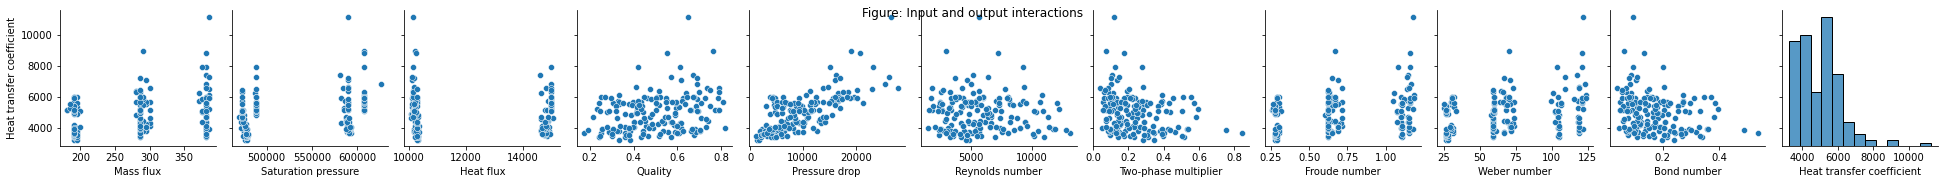

In [274]:
sns.pairplot(data=d, y_vars=['Heat transfer coefficient'])
plt.suptitle("Figure: Input and output interactions");

# Segmentation

We first apply an unsupervised PCA decomposition to the dataset in order to identify different patterns in the data. These segments are considered when sampling data for train/test and cross-validation operations as well as extrapolating performance.

## PCA definition

In [23]:
decpipeline = pipeline.Pipeline([
    ('scaler', impute.SimpleImputer(strategy='mean')),
    ('imputer', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=3))
])


# kerdecpipeline = pipeline.Pipeline([
#     # ("selector", preprocessing.FunctionTransformer(lambda x: x['Input Raw'])),
#     ('scaler', impute.SimpleImputer(strategy='mean')),
#     ('imputer', preprocessing.StandardScaler()),
#     ('pca', decomposition.KernelPCA(n_components=3, kernel='rbf', gamma=1e-3))
# ])


## Perform segmentation

In [593]:
%matplotlib inline
Xdec  = decpipeline.fit_transform(Xh, yh)
Xdecdp  = decpipeline.fit_transform(Xdp, ydp)

In [29]:
pd.DataFrame(decpipeline[2].components_.T, columns=['PCA1', 'PCA2', 'PCA3'], index=H_NAMES.drop([10, 11])) \
    .style.background_gradient(cmap='jet', vmin=-1, vmax=1) \
    .set_caption("Projection axes by input variables")

,PCA1,PCA2,PCA3
Mass flux,0.371403,0.336128,-0.052853
Saturation pressure,0.035643,-0.027975,0.788325
Heat flux,-0.031835,0.044657,0.605993
Quality,-0.338355,0.365280,0.057596
Pressure drop,0.072366,0.519421,0.003173
Reynolds number,0.456948,-0.059758,-0.012223
Two-phase multiplier,0.348064,-0.364637,0.024985
Froude number,0.379246,0.325789,-0.015902
Weber number,0.380145,0.321854,0.053131
Bond number,0.348953,-0.367088,0.036692


### 3d visualization

In [34]:
# import mlines
import matplotlib.lines as mlines
from ipywidgets import interact, interactive, fixed, interact_manual, FloatLogSlider

Given below in Figure 1 is a 3d visualization of the dataset using the first three principal components. The data is colored according to the value of heat transfer coefficient.

![](../img/pca.png)

*Figure 1*

By observing the PCA plot, we can see that the data is clustered into three distinct groups, mainly separated across first two principal components.

In the next step, we will use agglomerative clustering to segment the data into three groups with regard to the first two principal components. The results are given below in Figure 2.

## Assign clusters

In [594]:
# clusters = cluster.AgglomerativeClustering(n_clusters=3, linkage='single').fit_predict(Xdec[:, :2])
clusters = mixture.GaussianMixture(n_components=3, n_init=50, init_params='k-means++', max_iter=1000, tol=1e-6, ).fit_predict(Xdec[:, :2])
clustersdp = mixture.GaussianMixture(n_components=3, n_init=50, init_params='k-means++', max_iter=1000, tol=1e-6, ).fit_predict(Xdecdp[:, :2])
# clustersdp = cluster.AgglomerativeClustering(n_clusters=3, linkage='single').fit_predict(Xdecdp[:, :2])
# clustersdp = cluster.AgglomerativeClustering(n_clusters=3, linkage='single').fit_predict(Xdecdp[:, :2])
# clustersdp = cluster.DBSCAN().fit_predict(Xdecdp[:, :2])

### Visualize clusters

In [32]:
f1 = data_h['dataset'] == 'Plain tube h'
f2 = data_h['dataset'] == 'Microfin tube h'
f1dp = data_dp['dataset'] == 'Plain tube dp'
f2dp = data_dp['dataset'] == 'Microfin tube dp'



# Principal Component Analysis
                 
Apart from three distinct clusters, principal component analysis on the dataset also reveals a sub-seperation within each cluster by tube type. This is given below in Figure 2.
                 

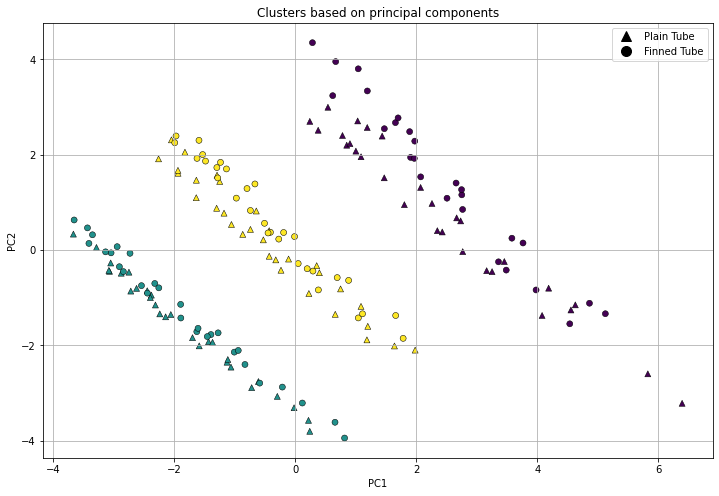

Figure 1: Data visualized in principal component space

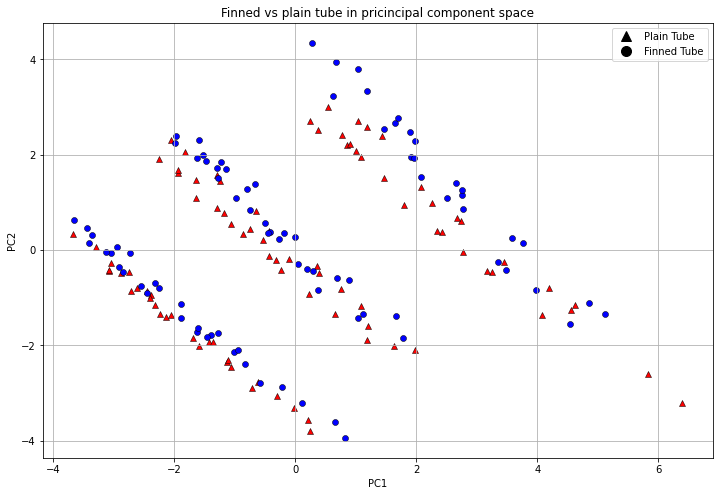

Figure 2: Finned vs plain tube in principal component space

In [40]:
display(Markdown("""
# Principal Component Analysis
                 
Apart from three distinct clusters, principal component analysis on the dataset also reveals a sub-seperation within each cluster by tube type. This is given below in Figure 2.
                 """))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
ax.scatter(Xdec[f1, 0], Xdec[f1, 1], 
    c=clusters[f1], 
    # color='red',
    cmap='viridis', linewidth=0.5, marker='^', edgecolors='black')
ax.scatter(Xdec[f2, 0], Xdec[f2, 1], 
           c=clusters[f2], 
        #    color='blue', 
           cmap='viridis', linewidth=0.5, marker='o', edgecolors='black')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.title("Clusters based on principal components")

# add legend
duz_boru = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                            markersize=10, label='Plain Tube')
mikrokanatli_boru = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                            markersize=10, label='Finned Tube')
ax.legend(handles=[duz_boru, mikrokanatli_boru]);
plt.grid()
plt.show()
display(Markdown("Figure 1: Data visualized in principal component space"))

# repeat plot for h colors

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
ax.scatter(Xdec[f1, 0], Xdec[f1, 1], 
    # c=clusters[f1], 
    color='red',
    cmap='viridis', linewidth=0.5, marker='^', edgecolors='black')
ax.scatter(Xdec[f2, 0], Xdec[f2, 1], 
        #    c=clusters[f2], 
           color='blue', 
           cmap='viridis', linewidth=0.5, marker='o', edgecolors='black')
plt.title("Finned vs plain tube in pricincipal component space")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.grid()
# add legend
duz_boru = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                            markersize=10, label='Plain Tube')
mikrokanatli_boru = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                            markersize=10, label='Finned Tube')
ax.legend(handles=[duz_boru, mikrokanatli_boru])
plt.show()
display(Markdown("Figure 2: Finned vs plain tube in principal component space"))

# Split

Dataset is split into two parts by stratified sampling across the cluster labels. The first part is used for training/validation and tuning of the model hyperparameters. The second part is used for testing the final model.

In [400]:
sample_category = data_h['dataset'] + " c:" + pd.Series(clusters).astype(str)

In [433]:
data_train, data_test, X_train, X_test, y_train, y_test, c_train, c_test = model_selection.train_test_split(
    data_h, 
    Xh, 
    yh, 
    clusters, 
    test_size=0.3, 
    random_state=42, 
    stratify=sample_category
    )
# data_train_dp, data_test_dp, X_train_dp, X_test_dp, y_train_dp, y_test_dp, c_train_dp, c_test_dp = model_selection.train_test_split(data_dp, Xdp, ydp, clustersdp, test_size=0.2, random_state=42, stratify=clustersdp)

# Define categories based on clusters and pipe type

Sample categories are defined based on PCA cluster membership and tube type.

In [434]:
cats = ((data_train['dataset'] + "_" + pd.Series(c_train, index = data_train.index).map({0: 'A', 1: 'B', 2: 'C'})).astype('category').cat.codes)
# cats_dp = ((data_train_dp['dataset'] + "_" + pd.Series(c_train_dp, index = data_train_dp.index).map({0: 'A', 1: 'B', 2: 'C'})).astype('category').cat.codes)

In [435]:
def renameH(df):
    df = df.copy()
    df.columns = H_NAMES
    return df

In [436]:
data_train.pipe(renameH).assign(Category=cats).groupby("Category").mean() \
    .style \
    .background_gradient(axis=0, cmap='Greens') \
    .set_caption("Input variable statistics by sample category")

,Mass flux,Saturation pressure,Heat flux,Quality,Pressure drop,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Heat transfer coefficient
Category,,,,,,,,,,,
0,381.581150,548121.666667,12316.211715,0.415239,16430.222222,8957.388960,0.301253,1.137289,114.199111,0.212395,6423.342882
1,190.393921,563453.500000,12099.940803,0.523582,6046.100000,3695.941125,0.219107,0.284798,28.918587,0.159377,5482.081313
2,286.044200,533894.285714,12467.265385,0.547884,13402.809524,5127.077934,0.187983,0.636063,63.225382,0.138451,5771.406042
3,380.549849,537139.616761,12295.173152,0.439079,10376.300000,8537.616703,0.294025,1.126977,112.277584,0.206425,4565.596511
4,191.583883,522792.743018,12977.271574,0.512505,3185.955045,3672.888004,0.217114,0.284181,28.003979,0.156907,3701.236073
5,289.701659,527019.157769,12959.948389,0.520686,7857.590909,5234.167764,0.184911,0.651301,64.468208,0.136821,4119.836011


# ML pipelines

## Scoring definitions

### $R^2$

$R^2$ is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. In this study, we use the following definition of $R^2$:

$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$

where $y_i$ is the true value of the $i$th sample, $\hat{y}_i$ is the predicted value of the $i$th sample, and $\bar{y}$ is the mean value of the true values.

It is important to note that $R^2$ can be biased upwards for models with more parameters, even if they are meaningless. This is called the [overfitting] phenomenon. To avoid this, we use the adjusted $R^2$ score, which is defined as:

$$ R^2_{adj} = 1 - \frac{(1 - R^2)(n - 1)}{n - p - 1} $$

where $n$ is the number of samples and $p$ is the number of model parameters.

### MAE

Mean absolute error (MAE) is a measure of difference between two continuous variables. For two vectors $y$ and $\hat{y}$, MAE is defined as:

$$ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

### RMSE

Root mean squared error (RMSE) is a quadratic scoring rule that also measures the average magnitude of the error. It is defined as:

$$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

$RMSE$ can be driven up by outliers and does not indicate under- or over-estimation. To address this issue, we use the mean absolute percentage error (MAPE) and weighted absolute percentage error (WAPE) scores whose details are given below that penalize errors relative to the true value.

### MAPE

Mean absolute percentage error (MAPE) is a measure of prediction accuracy of a forecasting method in statistics. For two vectors $y$ and $\hat{y}$, MAPE is defined as:

$$ MAPE = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| $$

### WAPE

Weighted absolute percentage error (WAPE) is a measure of prediction accuracy of a forecasting method in statistics. For two vectors $y$ and $\hat{y}$, WAPE is defined as:

$$ WAPE = \frac{100}{\sum_{i=1}^{n} y_i} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right| $$


### Weighted Bias %

Weighted percentage bias is a measure of systematic error in regression models. For two vectors $y$ and $\hat{y}$, weighted percentage bias is defined as:

$$ Weighted Bias \% = \frac{100}{\sum_{i=1}^{n} y_i} \sum_{i=1}^{n} \left( -y_i + \hat{y}_i \right) $$


Checking bias of the model is essential especially when modeling physical phenomena and built models are possibly used for extrapolation. In such cases, a model with a non-zero bias is not reliable.

### Pearson correlation coefficient

For two vectors $y$ and $\hat{y}$, Pearson correlation coefficient is defined as:

$$ R = \frac{(\sum_{i=1}^{n}{(\hat{y}_i - \bar{\hat{y}}})(y_i - \bar{y}))^2}{(\sum_{i=1}^{n}{(\hat{y}_i - \bar{\hat{y}})^2}) (\sum_{i=1}^{n}{(y_i - \bar{y})^2})} $$

*Taken from sample paper. Revisit this score to ensure it is actually capturing what we want.*

In [437]:
scoring={
    "R2": metrics.make_scorer(metrics.r2_score),
    "RMSE": metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False, squared=False),
    "MAE": metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False),
    "MAPE": metrics.make_scorer(metrics.mean_absolute_percentage_error, greater_is_better=False),
    "Bias%": metrics.make_scorer(bias, greater_is_better=False),
    "WAPE%": metrics.make_scorer(lambda x, y: metrics.mean_absolute_percentage_error(x, y, sample_weight=y), greater_is_better=False),
    "Pearson-R": metrics.make_scorer(pearson)
}

# Models

Different models are trained for each cluster. The models are trained using the training/validation dataset and tuned using the validation dataset. The final model is evaluated using the test dataset. The models are trained using the following algorithms:

* [ANN]
* [AdaBoost regressor of decision trees]
* [Locally weighted linear regression]

## MLP definition

ANN configuration we use in this study is as follows:

- Layer configurations
    - 40-10
    - 40-40-10
    - 20-20
    - 10-10
* Activation functions
    - ReLU
    - Sigmoid

In [438]:
from itertools import product

In [509]:
olcekli_ann = compose.TransformedTargetRegressor(
    regressor=neural_network.MLPRegressor(hidden_layer_sizes=(40, 10), max_iter=4000, random_state=42),
    # regressor=ensemble.RandomForestRegressor(),
    # regressor=lgb.LGBMRegressor(),
    # regressor=tree.DecisionTreeRegressor(),
    transformer=preprocessing.StandardScaler()
    # transformer=preprocessing.FunctionTransformer(np.log, inverse_func=np.exp)
    # transformer=preprocessing.FunctionTransformer(np.sqrt, inverse_func=np.square)
)


ans = ensemble.AdaBoostRegressor(base_estimator=olcekli_ann, n_estimators=1)

polylog = pipeline.Pipeline([
    ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
    ("log", preprocessing.FunctionTransformer(func=np.log1p, inverse_func=np.expm1))
])

union = pipeline.FeatureUnion([
#     ("sine", preprocessing.FunctionTransformer(np.sin)),
#     ("cosine", preprocessing.FunctionTransformer(np.cos)),
#     ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#     ("poly", polylog),
    # ("scaler", preprocessing.FunctionTransformer(lambda x: x))
    ("log", preprocessing.FunctionTransformer(func=np.log1p, inverse_func=np.expm1))
])

comp = compose.ColumnTransformer([
        ('a', "passthrough", Xh.columns)
    ], remainder='drop')


pipe = pipeline.Pipeline([
    ("comp", comp),
#     ("subselect", preprocessing.FunctionTransformer(lambda x: x['Input Raw'])),
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('ink', union),
    # ("pca", kerdecpipeline),
    ("rescale", preprocessing.StandardScaler()),
    ('mlp', olcekli_ann)
])



### Grid search for MLP

In [510]:
gs = model_selection.GridSearchCV(
    pipe,
    param_grid={
        # 'mlp__base_estimator__regressor__hidden_layer_sizes': [
        'mlp__regressor__hidden_layer_sizes': [
            # (10, 10, 10, 10, 10), 
            # (10, 10, 10, 10, 10, 10), 
            # (10, 10, 10, 10, 10, 10, 10),
#             (20, 20), 
#             (40, 10),
#             (40, 40, 10),
#             (20, 20),
#             (10, 10),
            (128, 64, 32, 16, 8,)
            # (50, 50), 
            # (10, 5),
            # (5, 5)
            ],
        # 'mlp__base_estimator__regressor__activation': ['relu', 'tanh', 'logistic'],
        'mlp__regressor__activation': [
            'relu', 
#             'logistic'
        ],
        # 'mlp__base_estimator__regressor__max_iter': [1000, 2000, 3000, 4000, 5000],
        # 'mlp__regressor__max_iter': [1000, 2000, 3000, 4000, 5000],

        # 'mlp__regressor__tol': [1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
        'mlp__regressor__tol': [1e-5],
    },
    cv=model_selection.KFold(n_splits=3, shuffle=True, random_state=42),
    scoring=scoring,
    refit="R2",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

#### Parameter size check

In [511]:
olcekli_ann.fit(pipe[:-1].fit_transform(Xh.ffill()), yh)
# print("Parametre sayisi")
# _a = sum(list(map(lambda x: x.size, olcekli_ann.regressor_.coefs_)))
# _b = sum(list(map(lambda x: x.size, olcekli_ann.regressor_.intercepts_)))
# print(_a + _b)

def getParamCount(estimator):
    _a = sum(list(map(lambda x: x.size, estimator.regressor_.coefs_)))
    _b = sum(list(map(lambda x: x.size, estimator.regressor_.intercepts_)))
    return _a + _b

getParamCount(olcekli_ann)

861

### ANN search

We use grid search to find the best hyperparameters for the ANN model. The hyperparameters we search are:

* `hidden_layer_sizes`: The number of neurons in the hidden layers
* `activation`: The activation function for the hidden layers
* `tolerance`: The tolerance for the optimization algorithm

Hyperparameter search is executed through a 3-fold cross validation scheme and train/test folds are stratified by 6 cluster labels described in Section x.

Training data is split into 10-folds by following the exact same stratification approach described above, and hyperparameter selection process is repeated on each fold. The best hyperparameters are selected based on the average performance across the folds. Results for each fold are given below in Table x.

In [512]:
cv = model_selection.cross_validate(
    # estimator=local_pipe_gs,
    estimator=gs,
    X=X_train, 
    y=y_train, 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     cv=model_selection.LeaveOneOut(),
    scoring=scoring,
    return_train_score=True, 
    return_estimator=True, 
    n_jobs=-1, 
    verbose=2,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


In [513]:
def renameScores(x):
    return x.replace("test_", "Test ").replace("train_", "Train ")

In [514]:
# pd.DataFrame(cv).sort_values(by='test_r2').set_index('estimator').rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).gamma ,n.n_neighbors))
tablo_ann = (
    pd.DataFrame(cv)
    .sort_values(by='test_R2')
    .set_index('estimator')
    .rename_axis("Selected ANN config")
    .rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).hidden_layer_sizes ,n.activation))
    )#.reset_index(drop=True).style.background_gradient(cmap='jet')

# get train scores

topten = tablo_ann[
    [col for col in tablo_ann.columns if 'test' in col]
    + [col for col in tablo_ann.columns if 'train' in col]
    ].sort_values('test_Pearson-R', ascending=False).reset_index().rename(renameScores , axis=1)
# display(tablo_ann[[col for col in tablo_ann.columns if 'train' in col]].loc[topten.index].style.set_caption("Table 5: Train scores for different ANN configurations"))
display(topten.rename_axis("Fold ID").style.set_caption("Table 5: Cross validation results for ANN configurations").background_gradient(cmap='Greens').background_gradient(cmap='jet', subset=['Test Bias%', 'Train Bias%'], vmin=-1, vmax=1))


# display(tablo_ann[[col for col in tablo_ann.columns if 'train' in col]].sort_values('train_pearson', ascending=False).head(10))

,Selected ANN config,Test R2,Test RMSE,Test MAE,Test MAPE,Test Bias%,Test WAPE%,Test Pearson-R,Train R2,Train RMSE,Train MAE,Train MAPE,Train Bias%,Train WAPE%,Train Pearson-R
Fold ID,,,,,,,,,,,,,,,
0,"((128, 64, 32, 16, 8), 'relu')",0.888522,-438.287645,-319.633235,-0.059315,0.032613,-0.060661,0.907520,0.997454,-61.073415,-27.230501,-0.005702,-0.000013,-0.005509,0.997456
1,"((128, 64, 32, 16, 8), 'relu')",0.887918,-403.506519,-289.090005,-0.056896,0.018136,-0.056997,0.897496,0.996676,-71.363531,-31.666441,-0.006296,-0.000155,-0.006341,0.996677
2,"((128, 64, 32, 16, 8), 'relu')",0.849518,-355.369062,-273.157789,-0.055838,0.001123,-0.056329,0.857040,0.997420,-65.916801,-28.181184,-0.005688,-0.000252,-0.005684,0.997426
3,"((128, 64, 32, 16, 8), 'relu')",0.846172,-644.917797,-440.702849,-0.076868,-0.006476,-0.087123,0.849687,0.998708,-39.681432,-21.837526,-0.004542,0.000314,-0.004405,0.998711
4,"((128, 64, 32, 16, 8), 'relu')",0.765984,-441.205194,-306.898073,-0.061103,0.028601,-0.059880,0.789489,0.997644,-62.949254,-37.099148,-0.007546,-0.000435,-0.007430,0.997648


In [515]:
tablo_ann.describe().pipe(lambda x: x[[c for c in x if "test" in c]]) \
    .T.drop("count", axis=1).round(4).rename(renameScores) \
    .style.set_caption("Scoring statistics for different models")

,mean,std,min,25%,50%,75%,max
Test R2,0.847600,0.049900,0.766000,0.846200,0.849500,0.887900,0.888500
Test RMSE,-456.657200,110.795500,-644.917800,-441.205200,-438.287600,-403.506500,-355.369100
Test MAE,-325.896400,66.552200,-440.702800,-319.633200,-306.898100,-289.090000,-273.157800
Test MAPE,-0.062000,0.008600,-0.076900,-0.061100,-0.059300,-0.056900,-0.055800
Test Bias%,0.014800,0.017000,-0.006500,0.001100,0.018100,0.028600,0.032600
Test WAPE%,-0.064200,0.012900,-0.087100,-0.060700,-0.059900,-0.057000,-0.056300
Test Pearson-R,0.860200,0.046800,0.789500,0.849700,0.857000,0.897500,0.907500


In [516]:
gs.fit(X_train, y_train, groups=cats.values);

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [517]:
y_pred = gs.predict(X_test)

In [518]:
y_pred_train = gs.predict(X_train)

In [519]:
scores = {}
for k, v in scoring.items():
    scores[k] = v._score_func(y_test, y_pred, **v._kwargs)

In [520]:
bias(y_test, y_pred)

0
Output 1    0.007895
dtype: float64

In [521]:
pd.Series(scores).to_frame()

,0
R2,0.635536
RMSE,712.153321
MAE,386.884512
MAPE,0.069008
Bias%,0 Output 1 0.007895 dtype: float64
WAPE%,0.084556
Pearson-R,0.727408


## Local Regression definition

In [542]:
ctlocal = compose.TransformedTargetRegressor(regressor=LocallyWeightedRegressor(n_neighbors=15, gamma=.1), 
                                            # func=np.log1p, 
                                            func=lambda x: x, 
                                            #  inverse_func=np.expm1
                                             inverse_func=lambda x: x
                                            )


local_pipe = pipeline.Pipeline([
#     ("subselect", preprocessing.FunctionTransformer(lambda x: x['Input Raw'])),
    ("comp", comp),
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('ink', union),
    ("rescale", preprocessing.StandardScaler()),
    ('mlp', ctlocal)
])

In [543]:
local_pipe_gs = model_selection.GridSearchCV(
    estimator=local_pipe,
    param_grid={
        'mlp__regressor__n_neighbors': [5, 10, 15, 20],
#         'mlp__regressor__n_neighbors': [1],
        'mlp__regressor__gamma': [.7, 1, 2, 3]
    },
    scoring=scoring,
    refit='R2',
    cv=3,
)
    

# Cross validation

In [544]:
cv_lwr = model_selection.cross_validate(
    estimator=local_pipe_gs,
    # estimator=gs,
    X=X_train, 
    y=y_train, 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     cv=model_selection.LeaveOneOut(),
    scoring=scoring,
    return_train_score=True, 
    return_estimator=True, 
    n_jobs=-1, 
    verbose=2,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


In [545]:
pd.DataFrame(cv_lwr).sort_values(by='test_R2', ascending=False) \
    .set_index('estimator') \
    .rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).gamma ,n.n_neighbors)) \
    .rename(renameScores, axis=1) \
    .rename_axis("Selected LWR config") \
    .filter(regex='(Train |Test )') \
    .reset_index() \
    .rename_axis("Fold ID") \
.style.set_caption("Cross validation scores for LWR configuration") \
    .background_gradient(cmap='Greens').background_gradient(cmap='jet', subset=['Test Bias%', 'Train Bias%'], vmin=-1, vmax=1)
    
    
# pd.DataFrame(cv).sort_values(by='test_r2').set_index('estimator').rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).hidden_layer_sizes ,n.activation)).reset_index(drop=True).style.background_gradient(cmap='jet')

,Selected LWR config,Test R2,Train R2,Test RMSE,Train RMSE,Test MAE,Train MAE,Test MAPE,Train MAPE,Test Bias%,Train Bias%,Test WAPE%,Train WAPE%,Test Pearson-R,Train Pearson-R
Fold ID,,,,,,,,,,,,,,,
0,"(1, 20)",0.861707,0.990906,-448.211998,-118.036172,-338.864866,-74.767513,-0.067940,-0.014605,0.004408,-0.000461,-0.069347,-0.015053,0.869623,0.991066
1,"(0.7, 20)",0.839132,0.978878,-526.501763,-175.904438,-394.648149,-102.811074,-0.080131,-0.020473,-0.013666,-0.001151,-0.079080,-0.021152,0.841959,0.980107
2,"(1, 20)",0.764520,0.993750,-797.927594,-87.288300,-579.472974,-58.688165,-0.111447,-0.012312,0.008738,-0.001406,-0.112230,-0.011944,0.767928,0.994058
3,"(2, 20)",0.679861,0.999690,-518.330203,-22.859286,-430.208728,-13.649102,-0.090214,-0.002838,0.021158,-0.000278,-0.082569,-0.002752,0.757496,0.999695
4,"(0.7, 20)",0.612126,0.980466,-568.019617,-181.254318,-497.766281,-110.418877,-0.105561,-0.021468,0.006662,-0.001224,-0.101537,-0.022439,0.757347,0.980869


In [546]:
model1 = gs
model2 = local_pipe_gs

# W

In [547]:
data_h['dataset'].unique()

array(['Plain tube h', 'Microfin tube h'], dtype=object)

In [548]:
# f = data_h['dataset'] == 'Plain tube h'
f = data_h['dataset'].notnull()
model1.fit(Xh, yh, 
#            groups=cats.values
          )
model2.fit(Xh, yh, 
#            groups=cats.values
          )


Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('comp',
                                        ColumnTransformer(transformers=[('a',
                                                                         'passthrough',
                                                                         MultiIndex([(       'Input Raw', 'Input 1'),
            (       'Input Raw', 'Input 2'),
            (       'Input Raw', 'Input 3'),
            (       'Input Raw', 'Input 4'),
            (       'Input Raw', 'Input 5'),
            ('Input Calculated', 'Input 1'),
            ('Input Calculated', 'Input 2'),
            ('Input Calculated', 'Input 3'),
            ('Input Calculated', 'Input 4'),
            ('Input Ca...
             scoring={'Bias%': make_scorer(bias, greater_is_better=False),
                      'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
                      'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                      'Pearson-R': make_scorer(pearson),
                      'R2': make_scorer(r2_score),
                      'RMSE': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
                      'WAPE%': make_scorer(<lambda>, greater_is_better=False)})

In [549]:
pd.DataFrame(model1.cv_results_).filter(regex="(param_|mean_test)").sort_values('mean_test_R2', ascending=False)

,param_mlp__regressor__activation,param_mlp__regressor__hidden_layer_sizes,param_mlp__regressor__tol,mean_test_R2,mean_test_RMSE,mean_test_MAE,mean_test_MAPE,mean_test_Bias%,mean_test_WAPE%,mean_test_Pearson-R
0,relu,"(128, 64, 32, 16, 8)",0.00001,0.657078,-686.966258,-396.035394,-0.072496,-0.005179,-0.085265,0.747166


In [550]:
pd.DataFrame(model2.cv_results_).filter(regex="(param_|mean_test)").sort_values('mean_test_R2', ascending=False).head(14)

,param_mlp__regressor__gamma,param_mlp__regressor__n_neighbors,mean_test_R2,mean_test_RMSE,mean_test_MAE,mean_test_MAPE,mean_test_Bias%,mean_test_WAPE%,mean_test_Pearson-R
3,0.7,20,-6.889574,-1674.856487,-1025.895627,-0.194348,-0.020360,-0.171175,0.396687
7,1,20,-6.909180,-1686.365729,-1025.832285,-0.194731,-0.023886,-0.173266,0.416443
11,2,20,-7.588568,-1794.639788,-1089.880496,-0.207248,-0.035195,-0.197956,0.458263
12,3,5,-8.195268,-2221.592541,-1643.629704,-0.336432,-0.012285,-0.338171,0.187097
0,0.7,5,-8.850410,-2220.828925,-1698.662859,-0.343923,-0.007421,-0.340414,0.182643
15,3,20,-8.941151,-1944.643723,-1165.852627,-0.221699,-0.042829,-0.231156,0.460443
4,1,5,-9.714635,-2315.911816,-1733.585798,-0.349236,0.011552,-0.325667,0.165704
8,2,5,-10.387848,-2383.545915,-1785.379004,-0.361764,-0.007493,-0.370463,0.175450
14,3,15,-19.492252,-2859.719316,-1711.818858,-0.326173,-0.044838,-0.373115,0.201366
10,2,15,-24.925779,-3237.840761,-1769.596559,-0.332655,-0.077744,-0.453552,0.273062


In [551]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)

In [552]:
scores1 = {}
scores2 = {}
for k, v in scoring.items():
    scores1[k] = v._score_func(y_test, y_pred1, **v._kwargs)
    scores2[k] = v._score_func(y_test, y_pred2, **v._kwargs)

In [553]:
x1 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred1.ravel()]).T
x2 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred2.ravel()]).T

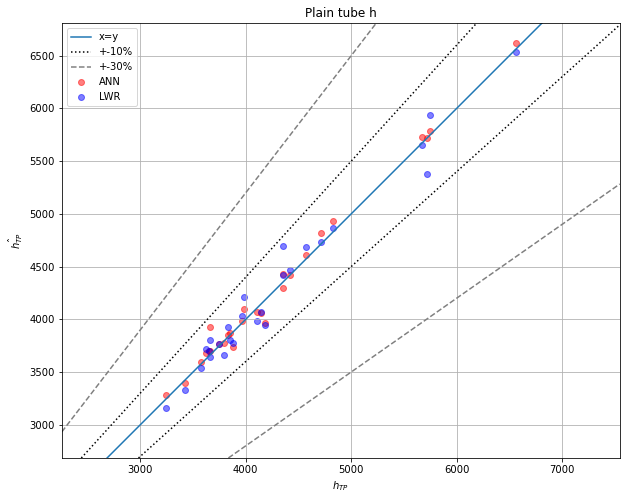

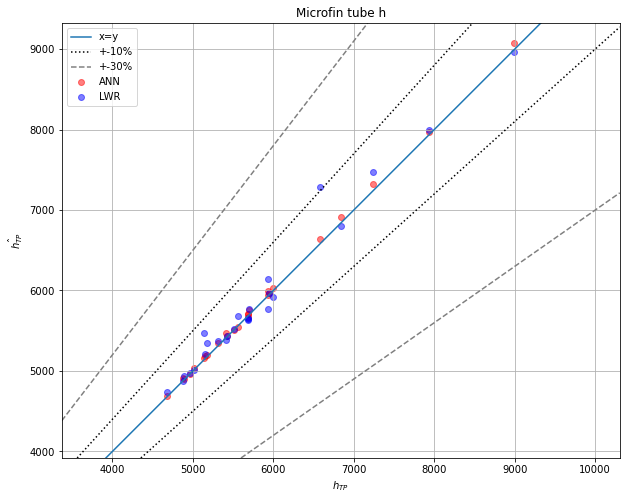

In [554]:
for t in data_h['dataset'].unique():
    f = data_test['dataset'] == t
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.scatter(y_test[f], y_pred1[f], color='red', label='ANN', alpha=0.5)
    plt.scatter(y_test[f], y_pred2[f], color='blue', label='LWR', alpha=0.5)
    xlims = tuple(ax.get_xlim())
    ylims = tuple(ax.get_ylim())

    ori = y_test[f].iloc[0,0]
    
    plt.grid()
    plt.axline((ori, ori), slope=1, label='x=y')
    plt.axline((ori,ori*1.1), slope=1.1, color='black', linestyle=':', label="+-10%")
    plt.axline((ori,ori*1.3), slope=1.3, color='gray', linestyle='--', label="+-30%")
    plt.axline((ori,ori*0.9), slope=0.9, color='black', linestyle=':')
    plt.axline((ori,ori*0.7), slope=0.7, color='gray', linestyle='--')

    plt.legend()
    plt.xlabel("$h_{TP}$")
    plt.ylabel("$\hat{h_{TP}}$")
    # plt.loglog()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims);
    plt.axis("equal")
    plt.title(t)


# Pressure Drop

PCA repeated for $\Delta P_t$


# Principal Component Analysis
                 
Apart from three distinct clusters, principal component analysis on the dataset also reveals a sub-seperation within each cluster by tube type.
                 

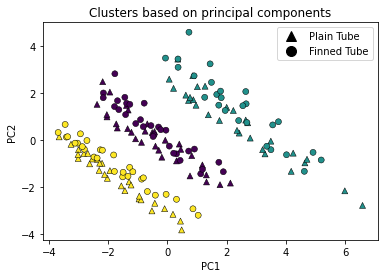

Figure 3: Data visualized in principal component space

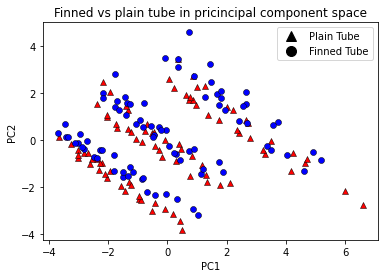

Figure 4: Finned vs plain tube in principal component space

In [596]:
display(Markdown("""
# Principal Component Analysis
                 
Apart from three distinct clusters, principal component analysis on the dataset also reveals a sub-seperation within each cluster by tube type.
                 """))

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xdecdp[f1dp, 0], Xdecdp[f1dp, 1], 
    c=clustersdp[f1dp], 
    # color='red',
    cmap='viridis', linewidth=0.5, marker='^', edgecolors='black')
ax.scatter(Xdecdp[f2dp, 0], Xdecdp[f2dp, 1], 
           c=clustersdp[f2dp], 
        #    color='blue', 
           cmap='viridis', linewidth=0.5, marker='o', edgecolors='black')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.title("Clusters based on principal components")

# add legend
duz_boru = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                            markersize=10, label='Plain Tube')
mikrokanatli_boru = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                            markersize=10, label='Finned Tube')
ax.legend(handles=[duz_boru, mikrokanatli_boru]);
plt.show()
display(Markdown("Figure 3: Data visualized in principal component space"))

# repeat plot for h colors

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xdecdp[f1dp, 0], Xdecdp[f1dp, 1], 
    # c=clustersdp[f1dp], 
    color='red',
    cmap='viridis', linewidth=0.5, marker='^', edgecolors='black')
ax.scatter(Xdecdp[f2dp, 0], Xdecdp[f2dp, 1], 
        #    c=clustersdp[f2dp], 
           color='blue', 
           cmap='viridis', linewidth=0.5, marker='o', edgecolors='black')
plt.title("Finned vs plain tube in pricincipal component space")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# add legend
duz_boru = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                            markersize=10, label='Plain Tube')
mikrokanatli_boru = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                            markersize=10, label='Finned Tube')
ax.legend(handles=[duz_boru, mikrokanatli_boru])
plt.show()
display(Markdown("Figure 4: Finned vs plain tube in principal component space"))

In [597]:
sample_category_dp = data_dp['dataset'] + " c:" + pd.Series(clustersdp).astype(str)

In [598]:
data_train, data_test, X_train, X_test, y_train, y_test, c_train, c_test = model_selection.train_test_split(
    data_dp, 
    Xdp, 
    ydp, 
    clustersdp, 
    test_size=0.3, 
    random_state=42, 
    stratify=sample_category_dp
    )
# data_train_dp, data_test_dp, X_train_dp, X_test_dp, y_train_dp, y_test_dp, c_train_dp, c_test_dp = model_selection.train_test_split(data_dp, Xdp, ydp, clustersdp, test_size=0.2, random_state=42, stratify=clustersdp)

In [602]:
cats = ((data_train['dataset'] + "_" + pd.Series(c_train, index = data_train.index).map({0: 'A', 1: 'B', 2: 'C'})).astype('category').cat.codes)

#### Parameter size check

In [599]:
olcekli_ann.fit(pipe[:-1].fit_transform(Xdp.ffill()), ydp)
# print("Parametre sayisi")
# _a = sum(list(map(lambda x: x.size, olcekli_ann.regressor_.coefs_)))
# _b = sum(list(map(lambda x: x.size, olcekli_ann.regressor_.intercepts_)))
# print(_a + _b)

def getParamCount(estimator):
    _a = sum(list(map(lambda x: x.size, estimator.regressor_.coefs_)))
    _b = sum(list(map(lambda x: x.size, estimator.regressor_.intercepts_)))
    return _a + _b

getParamCount(olcekli_ann)

861

### Grid search for MLP

In [603]:
cv = model_selection.cross_validate(
    # estimator=local_pipe_gs,
    estimator=gs,
    X=X_train, 
    y=y_train, 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     cv=model_selection.LeaveOneOut(),
    scoring=scoring,
    return_train_score=True, 
    return_estimator=True, 
    n_jobs=-1, 
    verbose=2,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


In [638]:
# pd.DataFrame(cv).sort_values(by='test_r2').set_index('estimator').rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).gamma ,n.n_neighbors))
tablo_ann = (
    pd.DataFrame(cv)
    .sort_values(by='test_R2')
    .set_index('estimator')
    .rename_axis("Selected ANN config")
    .rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).hidden_layer_sizes ,n.activation))
    )#.reset_index(drop=True).style.background_gradient(cmap='jet')

# get train scores

topten = tablo_ann[
    [col for col in tablo_ann.columns if 'test' in col]
    + [col for col in tablo_ann.columns if 'train' in col]
    ].sort_values('test_Pearson-R', ascending=False).reset_index().rename(renameScores , axis=1)
# display(tablo_ann[[col for col in tablo_ann.columns if 'train' in col]].loc[topten.index].style.set_caption("Table 5: Train scores for different ANN configurations"))

table89 = topten.rename_axis("Fold ID").style.set_caption("Table 5: Cross validation results for ANN configurations").background_gradient(cmap='Greens').background_gradient(cmap='jet', subset=['Test Bias%', 'Train Bias%'], vmin=-1, vmax=1)

# display(tablo_ann[[col for col in tablo_ann.columns if 'train' in col]].sort_values('train_pearson', ascending=False).head(10))

In [639]:
display(table89)

,Selected ANN config,Test R2,Test RMSE,Test MAE,Test MAPE,Test Bias%,Test WAPE%,Test Pearson-R,Train R2,Train RMSE,Train MAE,Train MAPE,Train Bias%,Train WAPE%,Train Pearson-R
Fold ID,,,,,,,,,,,,,,,
0,"((128, 64, 32, 16, 8), 'relu')",0.945605,-1208.289109,-873.773817,-0.094185,0.078139,-0.093381,0.973400,0.999543,-126.353125,-67.005370,-0.008362,0.000224,-0.007131,0.999544
1,"((128, 64, 32, 16, 8), 'relu')",0.667861,-3196.071742,-1723.776402,-0.149314,-0.147494,-0.215063,0.912978,0.998358,-236.152213,-127.846992,-0.016296,-0.000077,-0.013912,0.998360
2,"((128, 64, 32, 16, 8), 'relu')",0.861291,-2639.485384,-1348.118065,-0.124767,0.068073,-0.121065,0.891837,0.999431,-127.840517,-80.300720,-0.010948,-0.000084,-0.008851,0.999433
3,"((128, 64, 32, 16, 8), 'relu')",0.885614,-1864.507500,-1250.499175,-0.130712,-0.002707,-0.131163,0.885900,0.999362,-147.379469,-63.718417,-0.007360,0.000352,-0.006938,0.999364
4,"((128, 64, 32, 16, 8), 'relu')",0.871045,-1834.563962,-1361.691952,-0.218984,-0.037378,-0.184952,0.875476,0.999216,-165.372055,-84.691071,-0.011199,0.000429,-0.008934,0.999219


In [640]:
table90 = tablo_ann.describe().pipe(lambda x: x[[c for c in x if "test" in c]]) \
    .T.drop("count", axis=1).round(4).rename(renameScores) \
    .style.set_caption("Scoring statistics for different models")

In [641]:
display(table90)

,mean,std,min,25%,50%,75%,max
Test R2,0.846300,0.105000,0.667900,0.861300,0.871000,0.885600,0.945600
Test RMSE,-2148.583500,774.867300,-3196.071700,-2639.485400,-1864.507500,-1834.564000,-1208.289100
Test MAE,-1311.571900,303.791600,-1723.776400,-1361.692000,-1348.118100,-1250.499200,-873.773800
Test MAPE,-0.143600,0.046600,-0.219000,-0.149300,-0.130700,-0.124800,-0.094200
Test Bias%,-0.008300,0.091600,-0.147500,-0.037400,-0.002700,0.068100,0.078100
Test WAPE%,-0.149100,0.049600,-0.215100,-0.185000,-0.131200,-0.121100,-0.093400
Test Pearson-R,0.907900,0.039100,0.875500,0.885900,0.891800,0.913000,0.973400


In [606]:
gs.fit(X_train, y_train, groups=cats.values);

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [607]:
y_pred = gs.predict(X_test)

In [608]:
y_pred_train = gs.predict(X_train)

In [609]:
scores = {}
for k, v in scoring.items():
    scores[k] = v._score_func(y_test, y_pred, **v._kwargs)

In [611]:
pd.Series(scores).to_frame()

,0
R2,0.897189
RMSE,1901.448988
MAE,1243.773362
MAPE,0.133201
Bias%,0 Output 1 0.009646 dtype: float64
WAPE%,0.135805
Pearson-R,0.902407


## Local Regression definition

# Cross validation

In [612]:
cv_lwr = model_selection.cross_validate(
    estimator=local_pipe_gs,
    # estimator=gs,
    X=X_train, 
    y=y_train, 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     cv=model_selection.LeaveOneOut(),
    scoring=scoring,
    return_train_score=True, 
    return_estimator=True, 
    n_jobs=-1, 
    verbose=2,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


In [633]:
table91 = pd.DataFrame(cv_lwr).sort_values(by='test_R2', ascending=False) \
    .set_index('estimator') \
    .rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).gamma ,n.n_neighbors)) \
    .rename(renameScores, axis=1) \
    .rename_axis("Selected LWR config") \
    .filter(regex='(Train |Test )') \
    .reset_index() \
    .rename_axis("Fold ID") \
    .style.set_caption("Cross validation scores for LWR configuration") \
    .background_gradient(cmap='Greens', subset=['Test R2'], vmin=0.5, vmax=1) \
    .background_gradient(cmap='Greens', subset=['Test MAPE'], vmin=-1, vmax=0) \
    
    
# pd.DataFrame(cv).sort_values(by='test_r2').set_index('estimator').rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).hidden_layer_sizes ,n.activation)).reset_index(drop=True).style.background_gradient(cmap='jet')

In [635]:
display(table91)

,Selected LWR config,Test R2,Train R2,Test RMSE,Train RMSE,Test MAE,Train MAE,Test MAPE,Train MAPE,Test Bias%,Train Bias%,Test WAPE%,Train WAPE%,Test Pearson-R,Train Pearson-R
Fold ID,,,,,,,,,,,,,,,
0,"(2, 20)",0.928844,0.999807,-1381.973110,-82.030937,-1012.090809,-37.538878,-0.129193,-0.004122,0.004994,-0.000571,-0.114866,-0.004038,0.928919,0.999811
1,"(2, 20)",0.911261,0.999827,-1521.845303,-77.724213,-1184.948370,-38.104308,-0.295667,-0.004363,-0.036877,0.000208,-0.213278,-0.004003,0.918217,0.999827
2,"(0.7, 20)",0.887745,0.989372,-1847.062071,-601.456083,-1197.469020,-284.271737,-0.122714,-0.030038,0.030308,0.002809,-0.118475,-0.031049,0.895213,0.989663
3,"(1, 20)",0.850473,0.998083,-2740.476330,-234.683627,-1313.474811,-151.458686,-0.132369,-0.018398,0.060883,-0.001675,-0.124231,-0.016698,0.870959,0.998096
4,"(0.7, 20)",0.637976,0.997710,-3336.764771,-278.912668,-1937.611611,-205.275198,-0.178168,-0.026560,-0.055327,-0.003113,-0.212403,-0.022262,0.726628,0.997772


In [614]:
model1 = gs
model2 = local_pipe_gs

# W

In [615]:
# f = data_h['dataset'] == 'Plain tube h'
# f = data_h['dataset'].notnull()
model1.fit(Xdp, ydp, 
#            groups=cats.values
          )
model2.fit(Xdp, ydp, 
#            groups=cats.values
          )


Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('comp',
                                        ColumnTransformer(transformers=[('a',
                                                                         'passthrough',
                                                                         MultiIndex([(       'Input Raw', 'Input 1'),
            (       'Input Raw', 'Input 2'),
            (       'Input Raw', 'Input 3'),
            (       'Input Raw', 'Input 4'),
            (       'Input Raw', 'Input 5'),
            ('Input Calculated', 'Input 1'),
            ('Input Calculated', 'Input 2'),
            ('Input Calculated', 'Input 3'),
            ('Input Calculated', 'Input 4'),
            ('Input Ca...
             scoring={'Bias%': make_scorer(bias, greater_is_better=False),
                      'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
                      'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                      'Pearson-R': make_scorer(pearson),
                      'R2': make_scorer(r2_score),
                      'RMSE': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
                      'WAPE%': make_scorer(<lambda>, greater_is_better=False)})

In [616]:
pd.DataFrame(model1.cv_results_).filter(regex="(param_|mean_test)").sort_values('mean_test_R2', ascending=False)

,param_mlp__regressor__activation,param_mlp__regressor__hidden_layer_sizes,param_mlp__regressor__tol,mean_test_R2,mean_test_RMSE,mean_test_MAE,mean_test_MAPE,mean_test_Bias%,mean_test_WAPE%,mean_test_Pearson-R
0,relu,"(128, 64, 32, 16, 8)",0.00001,0.91681,-1632.234515,-1058.486247,-0.116997,-0.015478,-0.115671,0.920892


In [617]:
pd.DataFrame(model2.cv_results_).filter(regex="(param_|mean_test)").sort_values('mean_test_R2', ascending=False).head(14)

,param_mlp__regressor__gamma,param_mlp__regressor__n_neighbors,mean_test_R2,mean_test_RMSE,mean_test_MAE,mean_test_MAPE,mean_test_Bias%,mean_test_WAPE%,mean_test_Pearson-R
15,3,20,-1.475314,-6875.240064,-3167.337804,-0.318523,0.060593,-0.043743,0.374925
8,2,5,-2.405824,-9035.878014,-5651.609603,-0.671186,-0.043488,-0.474263,0.388119
11,2,20,-2.475773,-7407.604855,-3209.357335,-0.320049,0.092690,0.303263,0.396968
14,3,15,-2.755695,-10027.074507,-4840.647046,-0.513342,-0.032461,-0.830629,0.268640
3,0.7,20,-3.353458,-7673.541561,-3312.223962,-0.328291,0.127576,0.676111,0.444110
7,1,20,-3.355254,-7737.614593,-3309.472149,-0.327182,0.122915,0.657659,0.432168
12,3,5,-3.435441,-10002.163256,-5938.117955,-0.741399,-0.034093,-0.037366,0.351607
0,0.7,5,-3.457110,-9974.535298,-5861.572485,-0.724643,-0.039483,-0.016752,0.369644
4,1,5,-3.676124,-10173.403034,-5847.087705,-0.719973,-0.037366,0.095145,0.358397
10,2,15,-5.630047,-12521.250321,-5240.244166,-0.535149,-0.112566,-1.277276,0.221756


In [618]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)

In [619]:
scores1 = {}
scores2 = {}
for k, v in scoring.items():
    scores1[k] = v._score_func(y_test, y_pred1, **v._kwargs)
    scores2[k] = v._score_func(y_test, y_pred2, **v._kwargs)

In [620]:
x1 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred1.ravel()]).T
x2 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred2.ravel()]).T

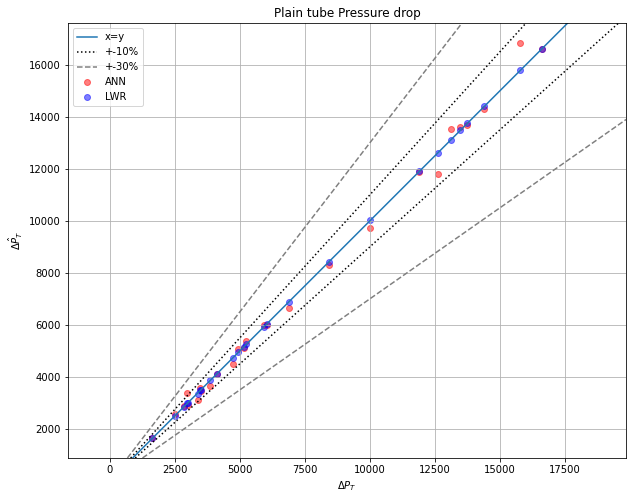

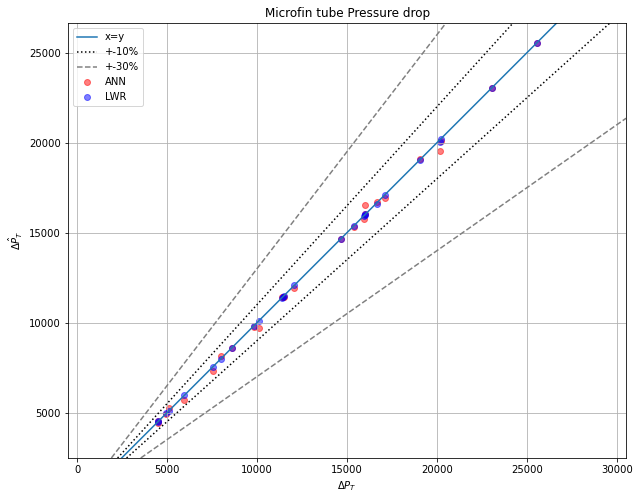

In [627]:
for t in data_dp['dataset'].unique():
    f = data_test['dataset'] == t
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.scatter(y_test[f], y_pred1[f], color='red', label='ANN', alpha=0.5)
    plt.scatter(y_test[f], y_pred2[f], color='blue', label='LWR', alpha=0.5)
    xlims = tuple(ax.get_xlim())
    ylims = tuple(ax.get_ylim())

    ori = y_test[f].iloc[-1,-1]
    
    plt.grid()
    plt.axline((ori, ori), slope=1, label='x=y')
    plt.axline((ori,ori*1.1), slope=1.1, color='black', linestyle=':', label="+-10%")
    plt.axline((ori,ori*1.3), slope=1.3, color='gray', linestyle='--', label="+-30%")
    plt.axline((ori,ori*0.9), slope=0.9, color='black', linestyle=':')
    plt.axline((ori,ori*0.7), slope=0.7, color='gray', linestyle='--')

    plt.legend()
    plt.xlabel("$\Delta P_T$")
    plt.ylabel("$\hat{\Delta P_T}$")
    # plt.loglog()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims);
    plt.axis("equal")
    plt.title(t.replace("dp", "Pressure drop"))


# Extrapolation analysis

In [642]:
data_train, data_test, X_train, X_test, y_train, y_test, c_train, c_test = model_selection.train_test_split(
    data_h, 
    Xh, 
    yh, 
    clusters, 
    test_size=0.02, 
    random_state=42, 
    stratify=sample_category
    )

In [730]:
h_gm = mixture.GaussianMixture(n_components=3, n_init=100, init_params='k-means++', max_iter=1000, tol=1e-6, )
h_pca = pipeline.Pipeline([
    ('scaler', impute.SimpleImputer(strategy='mean')),
    ('imputer', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=3))
])
h_cluster_pipeline = pipeline.Pipeline([
    ("pca", h_pca),
    ("gm", h_gm)
])

In [731]:
from sklearn import covariance

In [732]:
gm_h = h_cluster_pipeline.fit_predict(Xh)
pca_h = h_cluster_pipeline[:1].fit_transform(Xh)[:, :2]

In [749]:
Xh[gm_h == 0]

Input Raw                                                  \
0       Input 1        Input 2       Input 3   Input 4  Input 5   
8    295.110577  590521.073921  10199.073867  0.301865   3322.0   
9    295.110577  592297.558797  10183.667411  0.382805   4512.0   
10   299.870425  591190.957135  10204.209352  0.475266   5503.0   
11   299.870425  582291.959392  10224.078789  0.611808   9227.0   
12   290.350729  590592.902174  10290.371384  0.568620   6493.0   
..          ...            ...           ...       ...      ...   
164  285.590881  488370.000000  15000.000000  0.432495   9237.0   
165  285.590881  488370.000000  15000.000000  0.500567  11502.0   
166  285.590881  488370.000000  15000.000000  0.545985  13856.0   
167  285.590881  488370.000000  15000.000000  0.670668  18389.0   
168  285.590881  472880.000000  15000.000000  0.751137  20199.0   

    Input Calculated                                           
0            Input 1   Input 2   Input 3    Input 4   Input 5  
8        8541.113214  0.434919  0.690250  71.359051  0.299744  
9        7560.323979  0.314808  0.690702  71.492830  0.224970  
10       6526.372963  0.223691  0.712929  73.734392  0.166008  
11       4798.350812  0.134858  0.710832  73.057215  0.105697  
12       5192.706867  0.159495  0.668163  69.079721  0.122886  
..               ...       ...       ...        ...       ...  
164      6228.626139  0.237867  0.623865  59.889857  0.171787  
165      5481.499188  0.185891  0.623865  59.889857  0.137978  
166      4983.021706  0.157778  0.623865  59.889857  0.119265  
167      3614.570802  0.098211  0.623865  59.889857  0.078253  
168      2697.350935  0.067852  0.620368  58.858936  0.056141  

[61 rows x 10 columns]

In [846]:
outlier_indices = []
for c in range(3):
    f = Xh[gm_h == c]
    zz = h_pca[:2].transform(f)
    maho = covariance.LedoitWolf().fit(zz).mahalanobis(zz)
    outlier_indices += pd.Series(maho, index=f.index).sort_values(ascending=False).head(10).index.tolist()
    
#     outlier_indices += pd.DataFrame(h_cluster_pipeline.predict_proba(Xh), index=Xh.index)[c].apply(np.log)[gm_h==c].sort_values().head(10).index.tolist()

In [847]:
X_train = Xh.drop(outlier_indices)
X_test = Xh.loc[outlier_indices]
y_train = yh.drop(outlier_indices)
y_test = yh.loc[outlier_indices]

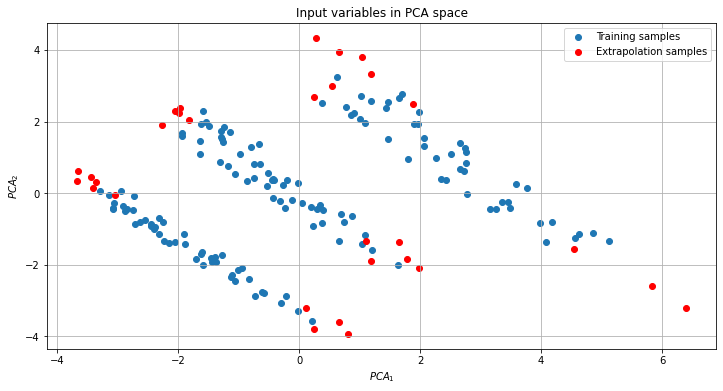

In [848]:
plt.figure(figsize=(12, 6))
plt.scatter(*h_cluster_pipeline[:1].transform(X_train)[:, :2].T, label='Training samples')
plt.scatter(*h_cluster_pipeline[:1].transform(X_test)[:, :2].T, color='red', label='Extrapolation samples')
plt.xlabel("$PCA_1$")
plt.ylabel("$PCA_2$")
plt.grid()
plt.legend()
plt.title("Input variables in PCA space");

In [849]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('comp',
                                        ColumnTransformer(transformers=[('a',
                                                                         'passthrough',
                                                                         MultiIndex([(       'Input Raw', 'Input 1'),
            (       'Input Raw', 'Input 2'),
            (       'Input Raw', 'Input 3'),
            (       'Input Raw', 'Input 4'),
            (       'Input Raw', 'Input 5'),
            ('Input Calculated', 'Input 1'),
            ('Input Calculated', 'Input 2'),
            ('Input Calculated', 'Input 3'),
            ('Input Calculated', 'Input 4'),
            ('Input Ca...
             scoring={'Bias%': make_scorer(bias, greater_is_better=False),
                      'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
                      'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                      'Pearson-R': make_scorer(pearson),
                      'R2': make_scorer(r2_score),
                      'RMSE': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
                      'WAPE%': make_scorer(<lambda>, greater_is_better=False)})

In [850]:
y_pred1 = model1.predict(X_test)
y_pred1 = pd.Series(y_pred1.ravel(), index=X_test.index)
y_pred2 = model2.predict(X_test)
y_pred2 = pd.Series(y_pred2.ravel(), index=X_test.index)


In [851]:
scores = {}
for k, v in scoring.items():
    scores[k] = v._score_func(y_test.values.ravel(), y_pred1, **v._kwargs)

In [852]:
table100 = pd.Series(scores).rename("Value").to_frame().rename_axis("Score").loc[['R2', 'MAPE', 'RMSE']].style.set_caption("Performance metrics for extrapolation of $h_{TP}$ on Plain tube")

In [853]:
display(table100)

,Value
Score,
R2,0.616472
MAPE,0.090640
RMSE,915.491837


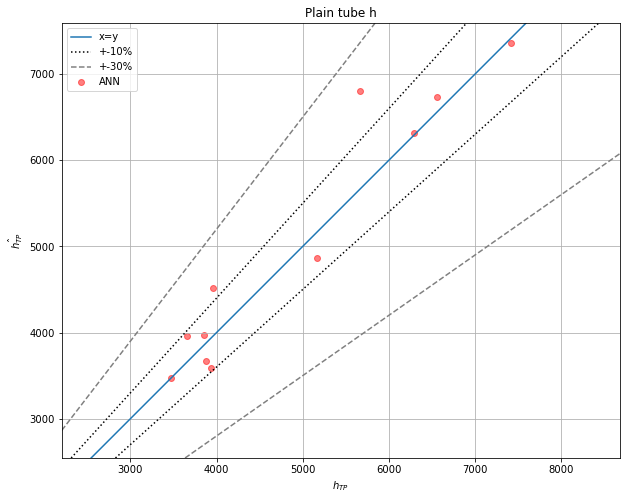

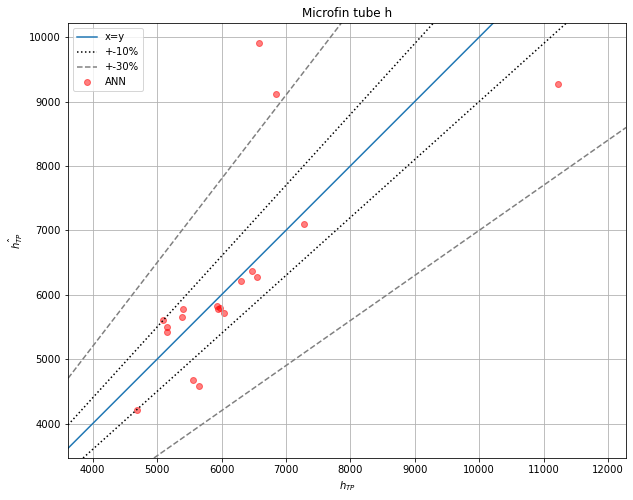

In [854]:
for t in data_h['dataset'].unique():
    f = data_h['dataset'][outlier_indices] == t
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.scatter(y_test[f], y_pred1[f], color='red', label='ANN', alpha=0.5)
#     plt.scatter(y_test[f], y_pred2[f], color='blue', label='LWR', alpha=0.5)
    xlims = tuple(ax.get_xlim())
    ylims = tuple(ax.get_ylim())

    ori = y_test[f].iloc[-1,-1]
    
    plt.grid()
    plt.axline((ori, ori), slope=1, label='x=y')
    plt.axline((ori,ori*1.1), slope=1.1, color='black', linestyle=':', label="+-10%")
    plt.axline((ori,ori*1.3), slope=1.3, color='gray', linestyle='--', label="+-30%")
    plt.axline((ori,ori*0.9), slope=0.9, color='black', linestyle=':')
    plt.axline((ori,ori*0.7), slope=0.7, color='gray', linestyle='--')

    plt.legend()
    plt.xlabel("$h_{TP}$")
    plt.ylabel("$\hat{h_{TP}}$")
    # plt.loglog()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims);
    plt.axis("equal")
    plt.title(t.replace("dp", "Pressure drop"))


In [862]:
deviations = np.abs(y_test.values.ravel() - y_pred.ravel()) / y_test.values.ravel()

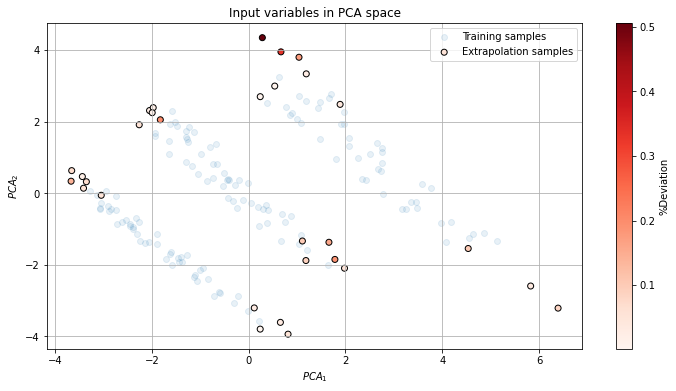

In [872]:
plt.figure(figsize=(12, 6))
plt.scatter(*h_cluster_pipeline[:1].transform(X_train)[:, :2].T, label='Training samples', alpha=0.1)
plt.scatter(*h_cluster_pipeline[:1].transform(X_test)[:, :2].T, c=deviations, label='Extrapolation samples', cmap='Reds', edgecolors='k')
plt.xlabel("$PCA_1$")
plt.ylabel("$PCA_2$")
plt.grid()
plt.legend()
plt.colorbar().set_label("%Deviation")
plt.title("Input variables in PCA space");